In [1]:
"""
각 feature가 무슨뜻인지 이해해 보고자 표로 정리해 본.. 하지만 큰 의미 없는 내용
heatmap은 여기 참고: https://www.kaggle.com/code/zhukovoleksiy/ps-s3e23-explore-data-stacking-ensemble/notebook 
"""

'\n각 feature가 무슨뜻인지 이해해 보고자 표로 정리해 본.. 하지만 큰 의미 없는 내용\nheatmap은 여기 참고: https://www.kaggle.com/code/zhukovoleksiy/ps-s3e23-explore-data-stacking-ensemble/notebook \n'

In [69]:
import sklearn
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)      # Show all rows

In [52]:
train = pd.read_csv('input/train.csv', index_col='id')
test = pd.read_csv('input/test.csv', index_col='id')
original = pd.read_csv('input/jm1.csv')

In [53]:
train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,0.02,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [55]:
table = PrettyTable()

table.field_names = [ 'name', 'desc', 'from', 'data type', 'explanations' ]

froms = {
    'loc':'loc code measure',
    'v(g)':'McCabe',
    'ev(g)':'McCabe',
    'iv(g)':'McCabe',
    'n':'Halstead derived',
    'v':'Halstead derived',
    'l':'Halstead derived',
    'd':'Halstead derived',
    'i':'Halstead derived',
    'e':'Halstead derived',
    'b':'Halstead derived',
    't':'Halstead derived',
    'lOCode':'loc code measure',
    'lOComment':'loc code measure',
    'lOBlank':'loc code measure',
    'locCodeAndComment':'loc code measure',
    'uniq_Op':'Halstead base',
    'uniq_Opnd':'Halstead base',
    'total_Op':'Halstead base',
    'total_Opnd':'Halstead base',
    'branchCount':'default'
}

descriptions = {
    'loc':'lines of code',
    'v(g)':'cyclomatic complexity',
    'ev(g)':'essential complexity',
    'iv(g)':'design complexity',
    'n':'total operators + operands',
    'v':'volume',
    'l':'program length',
    'd':'difficulty',
    'i':'intelligence',
    'e':'effort',
    'b':'Halstead',
    't':'time estimator',
    'lOCode':'line count',
    'lOComment':'count of lines of comments',
    'lOBlank':'count of blank lines',
    'locCodeAndComment':'numeric',
    'uniq_Op':'unique operators',
    'uniq_Opnd':'unique operands',
    'total_Op':'total operators',
    'total_Opnd':'total operands',
    'branchCount':'flow graph'
}

explanations = {
    'loc':'-',
    'v(g)':'# linearly independent paths',
    'ev(g)':'possibly reduced v(g)?',
    'iv(g)':'possibly reduced v(g)',
    'n':'#operators+#operands',
    'v':'n*log2(n_unique)',
    'l':'v* / n',
    'd':'1 / l',
    'i':'1/d * v',
    'e':'v / l',
    'b':'-',
    't':'e/18',
    'lOCode':'-',
    'lOComment':'-',
    'lOBlank':'-',
    'locCodeAndComment':'-',
    'uniq_Op':'-',
    'uniq_Opnd':'-',
    'total_Op':'-',
    'total_Opnd':'-',
    'branchCount':'-'
}

columns = train.drop(['defects'], axis=1).columns.to_list()
for column in columns:
    desc=descriptions[column]
    data_from=froms[column]
    data_exp=explanations[column]
    data_type = str(train[column].dtype)    
    
    table.add_row([column, desc, data_from, data_type, data_exp])


print('all variables are numerical (not categorical)')
    
print(table)

all variables are numerical (not categorical)
+-------------------+----------------------------+------------------+-----------+------------------------------+
|        name       |            desc            |       from       | data type |         explanations         |
+-------------------+----------------------------+------------------+-----------+------------------------------+
|        loc        |       lines of code        | loc code measure |  float64  |              -               |
|        v(g)       |   cyclomatic complexity    |      McCabe      |  float64  | # linearly independent paths |
|       ev(g)       |    essential complexity    |      McCabe      |  float64  |    possibly reduced v(g)?    |
|       iv(g)       |     design complexity      |      McCabe      |  float64  |    possibly reduced v(g)     |
|         n         | total operators + operands | Halstead derived |  float64  |     #operators+#operands     |
|         v         |           volume           |

In [65]:
subset = train.loc[1:20, ['loc', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment']]

# lOCode + lOComment + lOBlank + locCodeAndComment = loc ?? => NO
#subset['sum'] = subset['lOCode'] + subset['lOComment'] + subset['lOBlank'] + subset['locCodeAndComment']
#subset['diff'] = subset['loc'] - subset['sum']

# lOCode = lOComment + lOBlank + alpha ? => NO
#subset['sum'] = subset['lOComment'] + subset['lOBlank']
#subset['diff'] = subset['lOCode'] - subset['sum']

subset['loc'] = subset['loc'].astype(int)
print(subset)

    loc  lOCode  lOComment  lOBlank  locCodeAndComment
id                                                    
1    14      11          0        1                  0
2    11       8          0        1                  0
3     8       4          0        2                  0
4    11       7          0        2                  0
5    23      17          1        2                  0
6    24      19          0        3                  0
7    14      11          0        2                  0
8    34      29          1        3                  0
9     9       4          0        2                  0
10   16      14          0        0                  0
11    8       5          0        1                  0
12   19      11          2        5                  0
13   83      58         23       11                  1
14    6       3          0        0                  0
15   66      46          9        9                  0
16  126       0          0        0                  0
17    7   

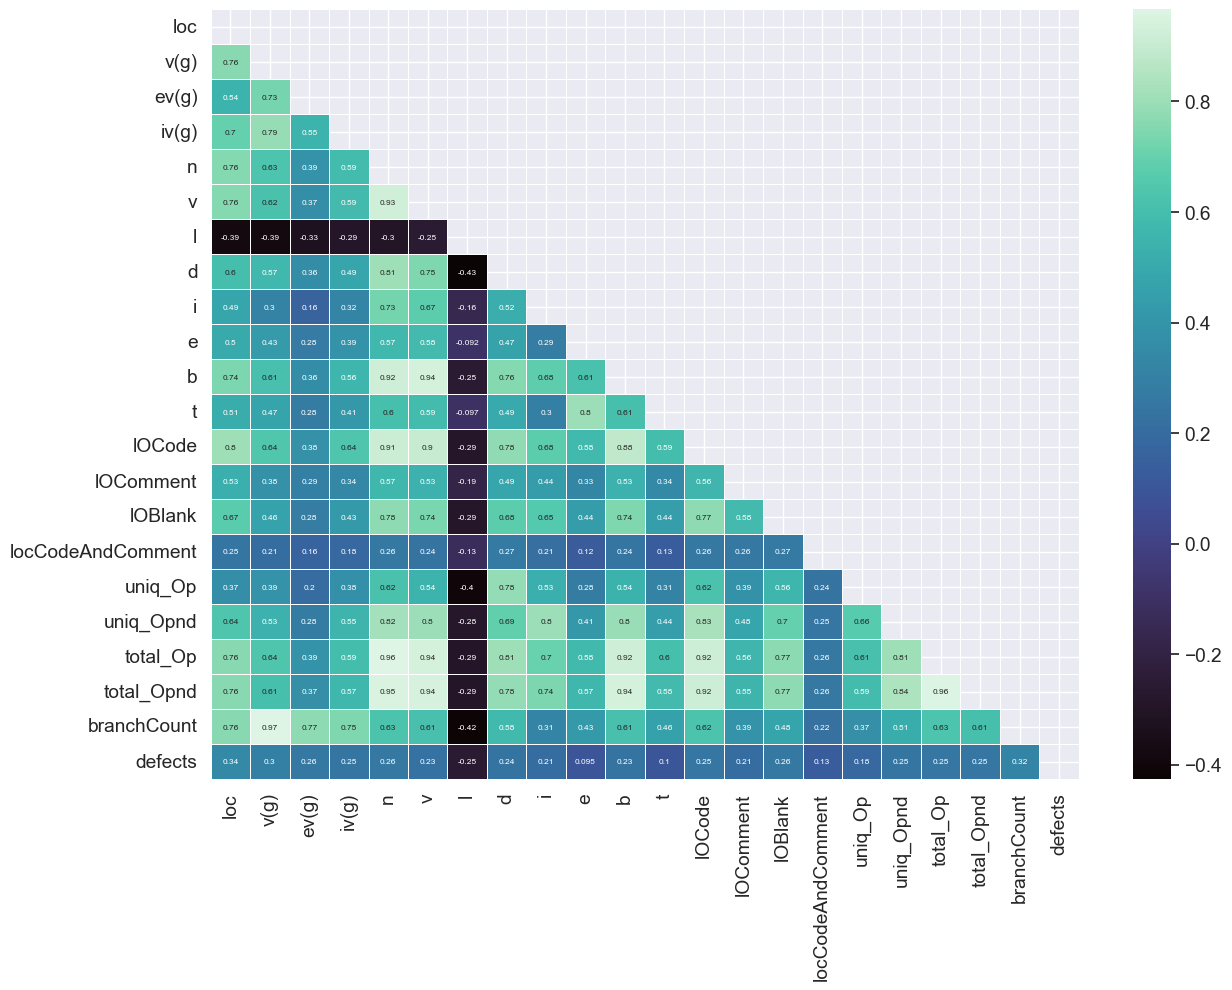

In [88]:
corr = train.corr()

fig, axes = plt.subplots(figsize=(14, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='mako', annot=True, annot_kws={"size": 6})
plt.show()

In [89]:
dropped = train.drop_duplicates(inplace=False)
dropped.dtypes

loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                 bool
dtype: object

In [91]:
for column in ['uniq_Op', 'uniq_Opnd', 'total_Op','total_Opnd', 'branchCount']:
    print(len(train[train[column] == '?']), train[train[column] == '?'].index)

0 Index([], dtype='int64', name='id')
0 Index([], dtype='int64', name='id')
0 Index([], dtype='int64', name='id')
0 Index([], dtype='int64', name='id')
0 Index([], dtype='int64', name='id')


In [92]:
original.dtypes

loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op               object
uniq_Opnd             object
total_Op              object
total_Opnd            object
branchCount           object
defects                 bool
dtype: object

In [93]:
for column in ['uniq_Op', 'uniq_Opnd', 'total_Op','total_Opnd', 'branchCount']:
    print(len(original[original[column] == '?']), original[original[column] == '?'].index)

5 Index([143, 358, 1598, 4214, 8279], dtype='int64')
5 Index([143, 358, 1598, 4214, 8279], dtype='int64')
5 Index([143, 358, 1598, 4214, 8279], dtype='int64')
5 Index([143, 358, 1598, 4214, 8279], dtype='int64')
5 Index([143, 358, 1598, 4214, 8279], dtype='int64')


In [94]:
test.dtypes

loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
dtype: object

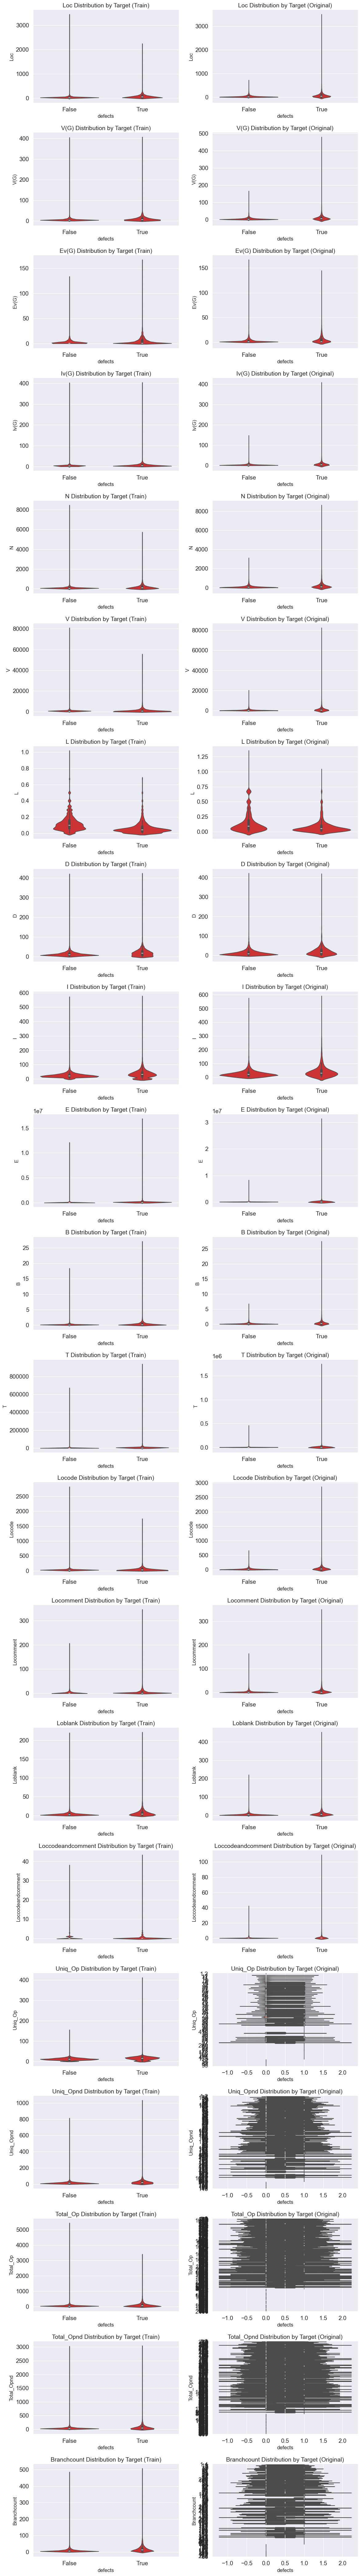

In [96]:
cont_cols = [f for f in train.columns if train[f].dtype != 'O' and train[f].nunique() > 2]
n_rows = len(cont_cols)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
sns.set_palette("Set1")

for i, col in enumerate(cont_cols):
    sns.violinplot(x='defects', y=col, data=train, ax=axs[i, 0])
    axs[i, 0].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i, 0].set_xlabel('defects', fontsize=12)
    axs[i, 0].set_ylabel(col.title(), fontsize=12)
    sns.despine()

    sns.violinplot(x='defects', y=col, data=original, ax=axs[i, 1])
    axs[i, 1].set_title(f'{col.title()} Distribution by Target (Original)', fontsize=14)
    axs[i, 1].set_xlabel('defects', fontsize=12)
    axs[i, 1].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()